# Задачи

1)  RFM-сегментация:
* https://emailsoldiers.ru/blog/rfm-analysis
* https://www.unisender.com/ru/blog/idei/rfm-analiz/
* https://www.putler.com/rfm-analysis/

2) разбиваем клиентов на сегментов по RFM

3) считаем следующие метрики:
* View2Order (orders/views) по сегментам и в динамике по дням и времени суток (разделить сутки на утро-день-вечер-ночь);
* Средний чек в разбивке по сегментам и городам;
* Order2Ride (исполняемость) - rides/orders;
* IQR по клиентскому чеку в разбивке по городу и сегменту.

Также без разбиения по сегментам:
* средняяя длительность поездок по часам;
* динамика ценообразования (делим клиентский чек в рублях на длительность поездки в минутах и получаем стоимость за минуту и смотрим, как этот показатель меняется в течение суток и дней недели);


**Дополнительные задачи**
<br> 1) Визуализировать количество просмотров цены, заказов и поездок по гексагонам
<br> 2) Визуализировать View2Order по гексагонам 
<br> гексагоны должны быть раскрашлены в зависимости от значения показателя
<br> Можно использовать библиотку h3 или kepler.gl

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import seaborn as sns
from clickhouse_driver import Client
from pandas_profiling import ProfileReport
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
#import h3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
client = Client('89.208.84.253',
                port= '59000',
                user='student',
                password='nUrHdn2N',
                secure=False,
                verify=True,
                database='data_analysis',
                compression=False)

In [3]:
result,columns = client.execute("""select *
from data_analysis.views
""",with_column_types=True)

In [4]:
views = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [5]:
views.head()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude
0,944452746,2015-12-14 19:43:26,Эконом,0,3923985705,2.52,57.622251,39.883861,57.636150,39.844848
1,1124126659,2015-12-14 19:43:28,Комфорт,0,1613934680,0.00,55.884660,37.408535,0.000000,0.000000
2,4108744040,2015-12-14 19:43:28,Эконом,0,112675651,5.57,57.696041,39.793804,57.677161,39.900115
3,2884954660,2015-12-14 19:43:29,Эконом,0,1584742787,3.31,57.571621,39.856915,57.610347,39.831193
4,3769769055,2015-12-14 19:43:30,Эконом,0,2202904080,5.99,55.768278,37.556728,55.774841,37.709461


In [6]:
df = views.sort_values(by='idhash_client')

In [7]:
#df.head(30)

In [8]:
a = views.groupby(['idhash_client'])['client_bill_usd'].sum() #monetary

In [9]:
b = views.groupby(['idhash_client'])['client_bill_usd'].count() #frequency

In [10]:
c = np.repeat(a, b)

In [11]:
df['monetary'] = list(c)

In [12]:
#len(a), len(b), len(c), len(d)

In [13]:
d = np.repeat(b, b)

In [14]:
df['frequency'] = list(d)

In [15]:
df.sort_values(by=['idhash_client','view_dttm'], ascending=False)

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude,monetary,frequency
500157,965331158,2015-12-16 22:21:38,Эконом,3313666818,4294689425,2.28,57.569902,39.874486,57.584148,39.824690,2.280,1
431740,4098547777,2015-12-09 23:26:04,Бизнес,0,4294586559,35.94,57.581192,39.861628,57.683617,39.806371,35.940,1
891647,1576826296,2015-12-19 21:05:27,Комфорт,0,4294468826,7.71,57.592882,39.862275,57.624080,39.852321,176.920,46
891228,2622366663,2015-12-19 21:01:49,Бизнес,0,4294468826,11.76,57.592882,39.862275,57.624080,39.852321,176.920,46
831540,3927740305,2015-12-19 00:38:19,Комфорт+,0,4294468826,4.62,57.626855,39.843030,57.624080,39.852321,176.920,46
...,...,...,...,...,...,...,...,...,...,...,...,...
410041,3717819686,2015-12-12 22:42:29,Бизнес,0,39262,5.16,57.584282,39.825794,57.584214,39.839829,54.655,25
384102,3018987483,2015-12-12 22:19:15,Эконом,0,39262,1.72,57.584282,39.825794,57.584214,39.839829,54.655,25
73332,2007943777,2015-12-08 22:28:51,Эконом,0,39262,1.86,57.584282,39.825794,57.584214,39.839829,54.655,25
73325,4139885053,2015-12-08 22:28:46,Эконом,2686729818,39262,1.86,57.584282,39.825794,57.584214,39.839829,54.655,25


In [16]:
tm = df.groupby(['idhash_client'])['view_dttm'].max() #recency

In [17]:
rfmTable = pd.DataFrame()

In [18]:
#rfmTable['client'] = a.keys()
rfmTable['recency'] = list(tm)
rfmTable['frequency'] = list(b)
rfmTable['monetary'] =list(a)

In [19]:
rfmTable['date'] = rfmTable['recency'].dt.date

In [20]:
#rfmTable.recency.max(), rfmTable['date'][0]

In [21]:
#rfmTable['weekday'] = rfmTable['recency'].dt.day_name()

In [22]:
rfmTable['date'] = rfmTable.date.max() - rfmTable['date']

In [23]:
rfmTable['recency'] = rfmTable['date'].dt.days

In [24]:
rfmTable.head()

,recency,frequency,monetary,date
0,0,25,54.655,0 days
1,5,4,13.250,5 days
2,0,10,36.510,0 days
3,0,6,30.540,0 days
4,0,6,23.570,0 days


In [25]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [26]:
quantiles

,recency,frequency,monetary
0.25,2.0,3.0,9.705
0.50,4.0,8.0,28.910
0.75,9.0,22.0,77.850


In [27]:
result,columns = client.execute("""select *
from data_analysis.orders
""",with_column_types=True)

In [28]:
orders = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [29]:
orders.head()

,idhash_order,idhash_view,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status
0,3777115420,95199865,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP
1,2983673012,3853062057,2015-12-06 00:00:11,2015-12-06 00:00:12,NaT,NaT,NaT,2015-12-06 00:01:26,CC
2,2177076394,147233410,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP
3,1997846256,518227239,2015-12-06 00:00:32,2015-12-06 00:00:41,2015-12-06 00:04:04,2015-12-06 00:06:08,2015-12-06 00:17:11,NaT,CP
4,1893504594,3623774808,2015-12-06 00:01:07,2015-12-06 00:04:46,2015-12-06 00:11:35,2015-12-06 00:13:01,2015-12-06 00:29:43,NaT,CP


## Creating the RFM segmentation table

In [30]:
rfmSegmentation = rfmTable

In [31]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [32]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary'].apply(FMClass, args=('monetary',quantiles,))

In [33]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [34]:
rfmSegmentation.head()

,recency,frequency,monetary,date,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,0,25,54.655,0 days,1,1,2,112
1,5,4,13.250,5 days,3,3,3,333
2,0,10,36.510,0 days,1,2,2,122
3,0,6,30.540,0 days,1,3,2,132
4,0,6,23.570,0 days,1,3,3,133


Топ 5 клиентов, которые больше всего тратят и покупают в последнее время
(id клиента можно найти исходя из RFM данных)

In [35]:
rfmSegmentation.sort_values(by='RFMClass', ascending=True).head() #top 5

,recency,frequency,monetary,date,R_Quartile,F_Quartile,M_Quartile,RFMClass
39272,2,274,1795.860,2 days,1,1,1,111
29952,0,135,472.040,0 days,1,1,1,111
38575,2,25,104.565,2 days,1,1,1,111
29951,0,111,456.380,0 days,1,1,1,111
38576,0,58,177.260,0 days,1,1,1,111


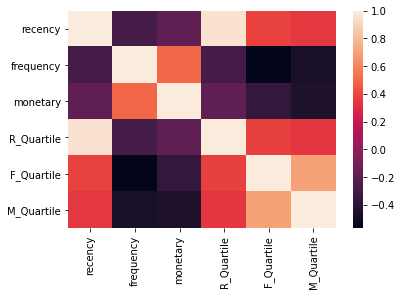

In [36]:
sns.heatmap(rfmSegmentation.iloc[:, 0:7].corr())

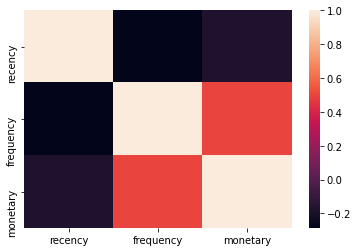

In [37]:
sns.heatmap(rfmSegmentation.iloc[:, 0:3].corr())

# Кластеризация

In [38]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(rfmTable[['R_Quartile', 'F_Quartile', 'M_Quartile']])
    #kmeans.fit(rfmSegmentation[['R_Quartile','F_Quartile', 'M_Quartile']])
    
    ssd.append(kmeans.inertia_)

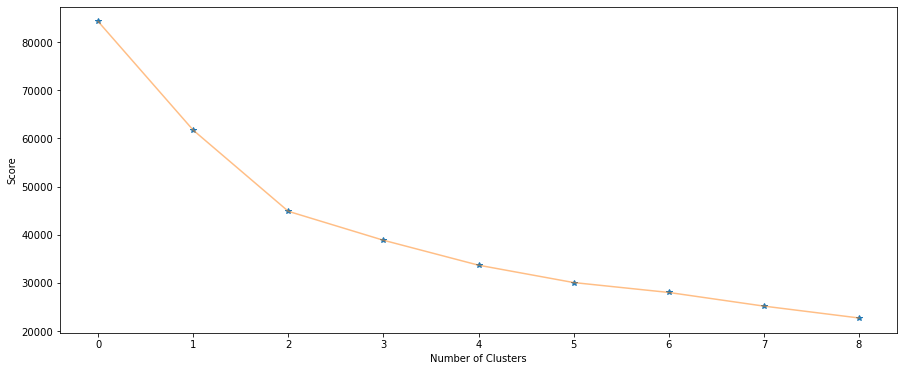

In [39]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(ssd , '*')
plt.plot(ssd , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Score')
plt.show()

In [40]:
#rfmTable_norm = pd.DataFrame()
#rfmTable.iloc[:, 4:7]

In [41]:
model = KMeans(n_clusters = 3, init ='k-means++',max_iter=1000,n_init=100,algorithm = 'elkan').fit(rfmTable.iloc[:, 4:7])
centers  = kmeans.cluster_centers_

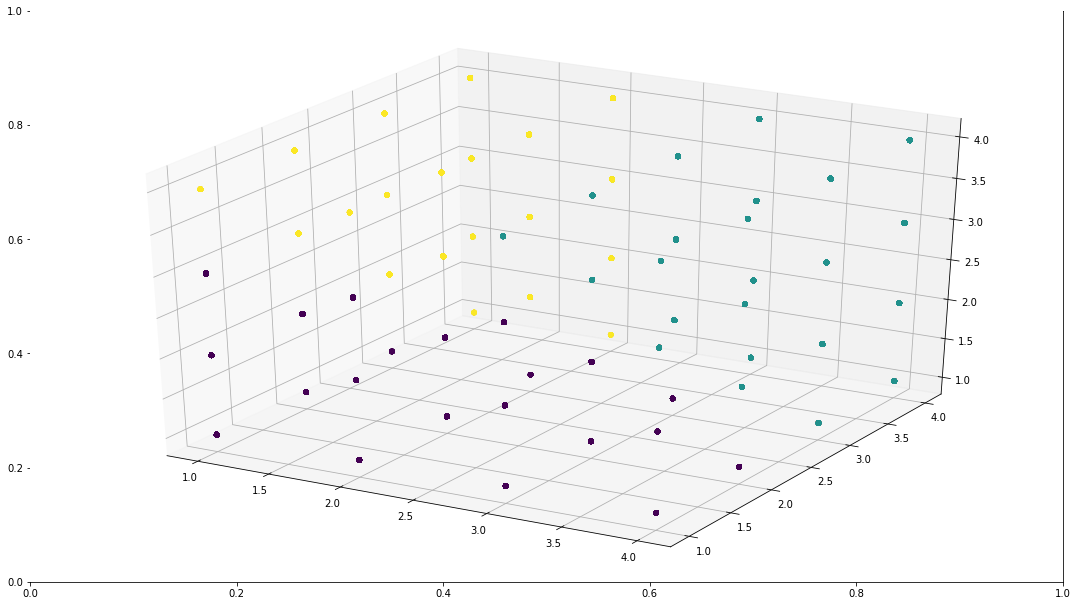

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection = '3d')
scatter = ax.scatter( rfmTable['R_Quartile'], rfmTable['F_Quartile'], rfmTable['M_Quartile'], 
                     #c = rfmTable['M_Quartile'])#,monetary,frequency 
                     c = model.predict(rfmTable.iloc[:, 4:7]))
plt.show()

In [43]:
labels = list(model.predict(rfmTable.iloc[:, 4:7]))

In [44]:
d = {'cluster_label':[0,1,2],'center':[centers[i] for i in set(labels)]}

In [45]:
center_info = pd.DataFrame(d)

In [46]:
center_info

,cluster_label,center
0,0,"[1.0000000000000495, 1.1697385340762323, 1.159..."
1,1,"[4.000000000000029, 3.8620215448085515, 3.7524..."
2,2,"[3.3504163997437324, 2.6504377535767674, 3.287..."


3) считаем следующие метрики:
* View2Order (orders/views) по сегментам и в динамике по дням и времени суток (разделить сутки на утро-день-вечер-ночь);
* Средний чек в разбивке по сегментам и городам;
* Order2Ride (исполняемость) - rides/orders;
* IQR по клиентскому чеку в разбивке по городу и сегменту.

In [47]:
rfmTable['client'] = a.keys()

In [48]:
rfmTable.head()

,recency,frequency,monetary,date,R_Quartile,F_Quartile,M_Quartile,RFMClass,client
0,0,25,54.655,0 days,1,1,2,112,39262
1,5,4,13.250,5 days,3,3,3,333,48902
2,0,10,36.510,0 days,1,2,2,122,199395
3,0,6,30.540,0 days,1,3,2,132,420016
4,0,6,23.570,0 days,1,3,3,133,658957


In [49]:
#rfmTable['lala'] = list(labels)

In [50]:
clusters = np.repeat(labels, b)

In [51]:
mt = np.repeat(tm, b)

In [52]:
df['recency'] = list(mt)

In [53]:
df['clusters'] = list(clusters)

In [54]:
df['date'] = df['recency'].dt.date

In [55]:
df['date'] = df.date.max() - df['date']

In [56]:
df['recency'] = df['date'].dt.days

In [57]:
#df.sort_values(by=['idhash_client','view_dttm'], ascending=False)
df = df.drop('date',axis = 1)

In [58]:
#list(rfmTable['R_Quartile'])

In [59]:
df['R_Quartile'] = np.repeat(list(rfmTable['R_Quartile']), b)
df['F_Quartile'] = np.repeat(list(rfmTable['F_Quartile']), b)
df['M_Quartile'] = np.repeat(list(rfmTable['M_Quartile']), b)
df['RFMClass'] = np.repeat(list(rfmTable['RFMClass']), b)

In [60]:
df.head()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude,monetary,frequency,recency,clusters,R_Quartile,F_Quartile,M_Quartile,RFMClass
73332,2007943777,2015-12-08 22:28:51,Эконом,0,39262,1.86,57.584282,39.825794,57.584214,39.839829,54.655,25,0,0,1,1,2,112
239922,1953603055,2015-12-15 22:50:07,Эконом,0,39262,2.20,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112
410722,3884522691,2015-12-12 22:53:33,Эконом,0,39262,1.72,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112
238269,1032456928,2015-12-15 22:31:55,Эконом,0,39262,1.46,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112
241018,646195412,2015-12-15 23:02:04,Эконом,0,39262,1.46,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112


#### View2Order по сегментам

In [61]:
view1 = df.groupby(['clusters'])['idhash_view'].count()

In [62]:
df = df[df['idhash_order'] != 0]

In [63]:
order1 = df.groupby(['clusters'])['idhash_order'].count()

In [64]:
View2Order_cluster = pd.DataFrame()

In [65]:
View2Order_cluster['cluster'] =view1.keys()
View2Order_cluster['views'] = list(view1)
View2Order_cluster['orders'] = list(order1)

In [66]:
View2Order_cluster

,cluster,views,orders
0,0,768573,59815
1,1,80823,10751
2,2,54145,8651


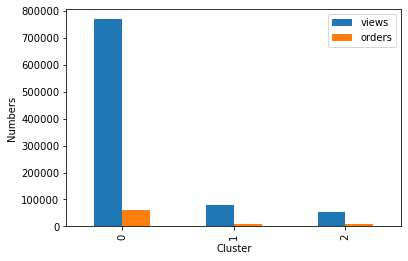

In [67]:
View2Order_cluster.iloc[:, 1:3].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Numbers')
plt.show()

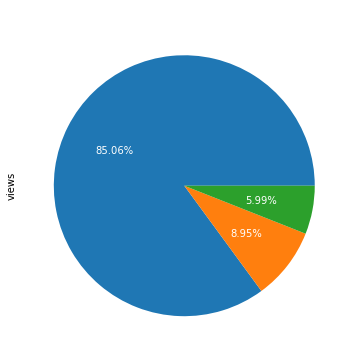

In [68]:
View2Order_cluster['views'].plot(kind='pie', autopct = "%.2f%%", textprops={'color':"w"}, figsize=(6,6))
plt.title('Views in clusters', color = 'w')
plt.show()

#### View2Order по дням

In [69]:
view2 = df.groupby(['recency'])['idhash_view'].count()

In [70]:
order2 = df.groupby(['recency'])['idhash_order'].count()

In [71]:
View2Order_days = pd.DataFrame()

In [72]:
View2Order_days['days'] =view2.keys()
View2Order_days['views'] = list(view2)
View2Order_days['orders'] = list(order2)

дни отсчитаны начиная с даты 2015-12-19

In [73]:
View2Order_days

,days,views,orders
0,0,29199,29199
1,2,17632,17632
2,3,7376,7376
3,4,4650,4650
4,5,3359,3359
5,6,3003,3003
6,7,3104,3104
7,8,2812,2812
8,9,2571,2571
9,10,2396,2396


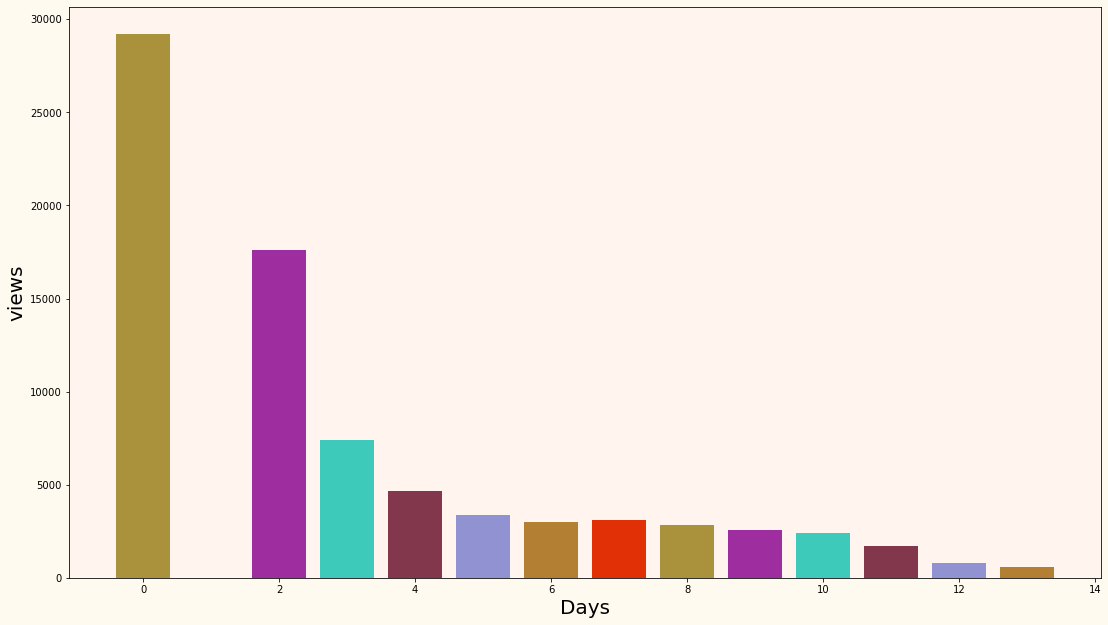

In [74]:
x = View2Order_days['days']
y = View2Order_days['views']

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

color_rectangle = np.random.rand(7, 3)    # RGB
ax.bar(x, y, color = color_rectangle)

plt.xlabel('Days', fontsize=20)
plt.ylabel('views', fontsize=20)
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

#### View2Order по времени суток

In [75]:
df.head(2)

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude,monetary,frequency,recency,clusters,R_Quartile,F_Quartile,M_Quartile,RFMClass
73325,4139885053,2015-12-08 22:28:46,Эконом,2686729818,39262,1.86,57.584282,39.825794,57.584214,39.839829,54.655,25,0,0,1,1,2,112
898708,3709831592,2015-12-19 22:42:40,Комфорт,2761390152,39262,2.79,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112


In [76]:
df['hour'] = df['view_dttm'].dt.hour

In [77]:
#df.sort_values(by=['hour'], ascending=False).head(2)
df.tail()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude,monetary,frequency,recency,clusters,R_Quartile,F_Quartile,M_Quartile,RFMClass,hour
794963,75892518,2015-12-17 22:45:20,Эконом,2949569858,4294468826,2.01,57.626236,39.838350,57.624080,39.852321,176.92,46,0,0,1,1,1,111,22
613631,3143083069,2015-12-13 21:47:56,Эконом,759999585,4294468826,3.31,57.591675,39.866699,57.624080,39.852321,176.92,46,0,0,1,1,1,111,21
675081,3473992266,2015-12-14 07:25:06,Бизнес,2791065179,4294468826,4.14,57.623240,39.851656,57.615144,39.851935,176.92,46,0,0,1,1,1,111,7
603790,2241874340,2015-12-17 10:52:29,Эконом,1016393930,4294468826,1.83,57.623240,39.851656,57.625915,39.835649,176.92,46,0,0,1,1,1,111,10
500157,965331158,2015-12-16 22:21:38,Эконом,3313666818,4294689425,2.28,57.569902,39.874486,57.584148,39.824690,2.28,1,3,2,2,4,4,244,22


утро - с 6 до 11
<br>день - с 11 до 16
<br>вечер - с 16 до 22
<br>ночь - с 22 до 6

In [78]:
def f(x):
    if (x > 5) and (x <= 11):
        return 'Morning'
    elif (x > 11) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 22) :
        return 'Evening'
    else:
        return'Night'

In [79]:
df['phase'] = df['hour'].apply(f)

In [80]:
#df.sort_values(by=['hour'])

In [81]:
view3 = df.groupby(['phase'])['idhash_view'].count()

In [82]:
order3 = df.groupby(['phase'])['idhash_order'].count()

In [83]:
View2Order_phase = pd.DataFrame()

In [84]:
View2Order_phase['phase'] =view3.keys()
View2Order_phase['views'] = list(view3)
View2Order_phase['orders'] = list(order3)

In [85]:
View2Order_phase

,phase,views,orders
0,Evening,25871,25871
1,Morning,21450,21450
2,Night,15277,15277
3,Noon,16619,16619


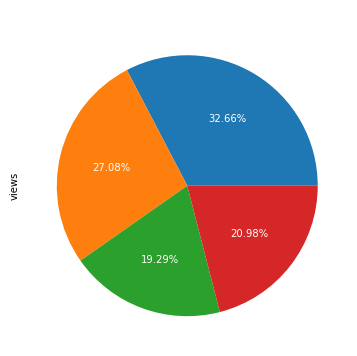

In [86]:
View2Order_phase['views'].plot(kind='pie', labels = View2Order_phase['phase'],
                               autopct = "%.2f%%", textprops={'color':"w"}, figsize=(6,6))
plt.title('Views in day phases', color = 'w')
plt.show()

#### Средний чек в разбивке по сегментам

In [87]:
df.head()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude,monetary,frequency,recency,clusters,R_Quartile,F_Quartile,M_Quartile,RFMClass,hour,phase
73325,4139885053,2015-12-08 22:28:46,Эконом,2686729818,39262,1.86,57.584282,39.825794,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening
898708,3709831592,2015-12-19 22:42:40,Комфорт,2761390152,39262,2.79,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening
410068,731098178,2015-12-12 22:42:56,Эконом,790101098,39262,1.72,57.584282,39.825794,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening
238308,4241509287,2015-12-15 22:32:20,Эконом,4076411177,39262,1.46,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening
410409,3978633497,2015-12-12 22:47:35,Эконом,1339001373,39262,1.72,57.584268,39.825746,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening


In [88]:
bill = df.groupby(['clusters'])['client_bill_usd'].mean()

In [89]:
check_cluster = pd.DataFrame()

In [90]:
check_cluster['cluster'] =bill.keys()
check_cluster['bill'] = list(bill)

In [91]:
check_cluster

,cluster,bill
0,0,4.663874
1,1,4.649749
2,2,4.162358


#### Средний чек в разбивке по городам

In [92]:
import keplergl

In [93]:
coord=df.loc[:,['idhash_client', 'client_bill_usd','latitude','longitude']]

In [94]:
coord['location'] = coord[['latitude','longitude']].values.tolist()

In [95]:
coord.head(3)

,idhash_client,client_bill_usd,latitude,longitude,location
73325,39262,1.86,57.584282,39.825794,"[57.58428192, 39.82579422]"
898708,39262,2.79,57.584267,39.825745,"[57.58426666, 39.82574463]"
410068,39262,1.72,57.584282,39.825794,"[57.58428192, 39.82579422]"


In [96]:
geolocator = Nominatim(user_agent="polina1")

In [97]:
def get_city(locations):
    cities = []
    for location in locations:
        cities.append(geolocator.reverse(location).raw['address'].get('state'))
    return cities

In [98]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(coord[['latitude','longitude']])
    
    ssd.append(kmeans.inertia_)

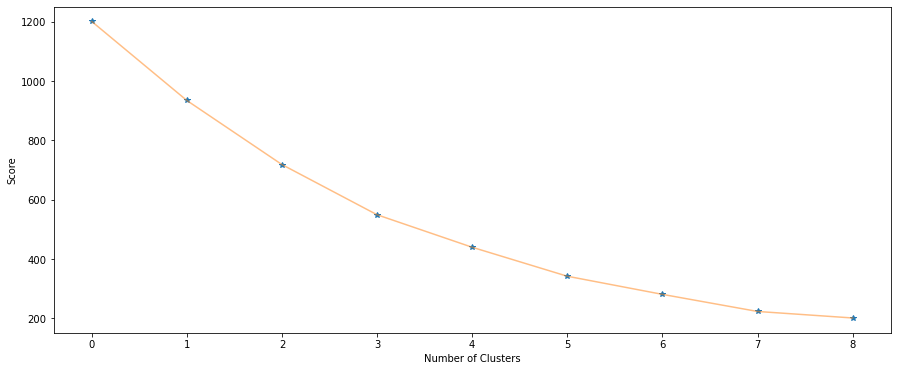

In [99]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(ssd , '*')
plt.plot(ssd , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Score')
plt.show()

In [100]:
kmeans = KMeans(n_clusters = 6, init ='k-means++',max_iter=300,n_init=10,algorithm = 'elkan')
kmeans.fit(coord[['latitude','longitude']]) 
coord['cluster_label'] = kmeans.fit_predict(coord[coord.columns[2:4]])
labels = kmeans.predict(coord[['latitude','longitude']]) 
centroids  = kmeans.cluster_centers_
centroid_labels = [centroids[i] for i in labels]
coord['center'] = centroid_labels

In [101]:
centroids

array([[57.61774429, 39.87652596],
       [56.18831445, 40.39955724],
       [57.35308912, 41.02819429],
       [57.68233223, 39.78236088],
       [57.5842438 , 38.79433393],
       [59.19304323, 39.90428194]])

In [102]:
#coord.sort_values(by=['location'], ascending=False).head(2)

Посмотрим на размеры получившихся кластеров.

In [103]:
coord.groupby('cluster_label')['idhash_client'].count()

cluster_label
0    62806
1      353
2      323
3    15496
4      191
5       48
Name: idhash_client, dtype: int64

Создадим отдельный датафрейм где будет содержаться только центр кластера и его координаты, чтобы получить геокодирование для этих центров.

In [104]:
d = {'cluster_label':[0,1,2,3,4,5],'center': list(centroids)}

In [105]:
center_info = pd.DataFrame(d)

In [106]:
center_info

,cluster_label,center
0,0,"[57.61774428697909, 39.87652596134591]"
1,1,"[56.188314447308784, 40.39955723628895]"
2,2,"[57.3530891179257, 41.0281942947678]"
3,3,"[57.68233223434864, 39.782360882320184]"
4,4,"[57.58424380010471, 38.794333928376965]"
5,5,"[59.193043234375, 39.9042819375]"


In [107]:
center_info['city'] = get_city(center_info['center'])

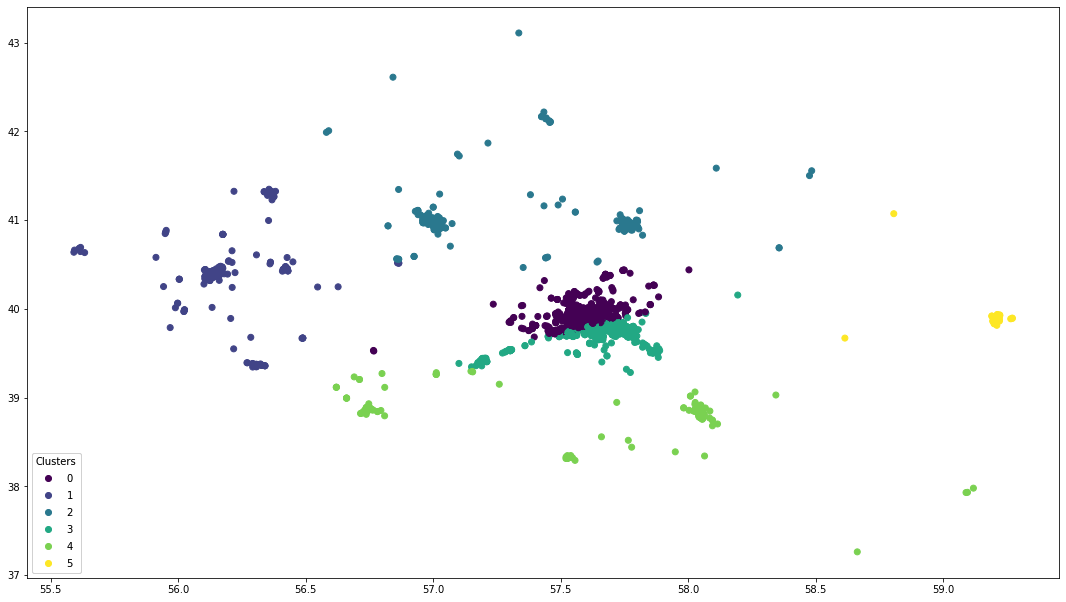

In [108]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

scatter = ax.scatter(coord['latitude'], coord['longitude'], c= coord['cluster_label'])


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)


handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

plt.show()

In [109]:
center_info = center_info[['cluster_label','city']]

In [110]:
center_info

,cluster_label,city
0,0,Ярославская область
1,1,Владимирская область
2,2,Костромская область
3,3,Ярославская область
4,4,Ярославская область
5,5,Вологодская область


In [111]:
coord = coord[['idhash_client','cluster_label']]

In [112]:
geo =  center_info.join(coord.set_index('cluster_label'), on='cluster_label',how = 'inner')

In [113]:
geo.head()

,cluster_label,city,idhash_client
0,0,Ярославская область,39262
0,0,Ярославская область,39262
0,0,Ярославская область,39262
0,0,Ярославская область,39262
0,0,Ярославская область,39262


In [114]:
geo1 = geo.join(views.set_index('idhash_client'), on='idhash_client')

In [115]:
geo1

,cluster_label,city,idhash_client,idhash_view,view_dttm,tariff,idhash_order,client_bill_usd,latitude,longitude,del_latitude,del_longitude
0,0,Ярославская область,39262,156843244,2015-12-08 22:28:23,Эконом,0,1.86,57.584282,39.825794,57.584214,39.839829
0,0,Ярославская область,39262,4139885053,2015-12-08 22:28:46,Эконом,2686729818,1.86,57.584282,39.825794,57.584214,39.839829
0,0,Ярославская область,39262,2007943777,2015-12-08 22:28:51,Эконом,0,1.86,57.584282,39.825794,57.584214,39.839829
0,0,Ярославская область,39262,2066483825,2015-12-15 22:23:55,Эконом,0,1.46,57.584267,39.825745,57.584214,39.839829
0,0,Ярославская область,39262,1032456928,2015-12-15 22:31:55,Эконом,0,1.46,57.584267,39.825745,57.584214,39.839829
...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,Вологодская область,4112524367,3362664442,2015-12-10 21:46:41,Комфорт+,0,4.24,59.217648,39.900810,59.204015,39.833033
5,5,Вологодская область,4131089333,3734484891,2015-12-11 20:39:25,Эконом,0,3.82,59.197512,39.860454,59.230253,39.868887
5,5,Вологодская область,4131089333,820013879,2015-12-11 20:39:39,Эконом,0,3.82,59.197512,39.860454,59.229511,39.871176
5,5,Вологодская область,4131089333,3346347154,2015-12-11 20:39:52,Эконом,391784762,3.82,59.197512,39.860454,59.229511,39.871176


In [116]:
av_bill =  geo1.groupby('city')['client_bill_usd'].mean()

In [117]:
av_bill_city = pd.DataFrame(av_bill)

In [118]:
av_bill_city

,client_bill_usd
city,
Владимирская область,23.497106
Вологодская область,7.591019
Костромская область,8.072168
Ярославская область,4.295530


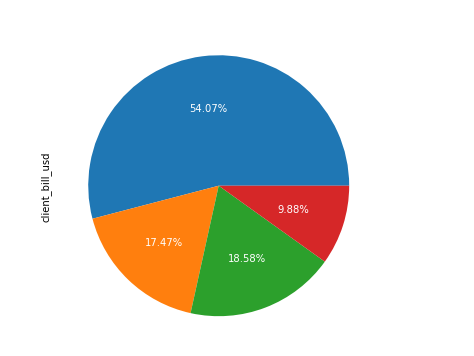

In [119]:
av_bill_city['client_bill_usd'].plot(kind='pie', autopct = "%.2f%%", textprops={'color':"w"}, figsize=(6,6))
plt.title('Views in clusters', color = 'w')
plt.show()

####  Order2Ride (исполняемость) - rides/orders

In [120]:
data = orders.drop(['idhash_view'],axis = 1).join(df.set_index('idhash_order'), on='idhash_order',how = 'inner')

In [121]:
ord1 = df.groupby(['clusters'])['idhash_order'].count()

In [122]:
ord1

clusters
0    59815
1    10751
2     8651
Name: idhash_order, dtype: int64

In [123]:
data['status'] = 'CP'

In [124]:
ride1 = data.groupby(['clusters'])['status'].count()

In [125]:
ride1

clusters
0    58805
1    10642
2     8581
Name: status, dtype: int64

In [126]:
Order2Ride = pd.DataFrame()

In [127]:
Order2Ride['cluster'] =ord1.keys()
Order2Ride['orders'] = list(ord1)
Order2Ride['rides'] = list(ride1)

In [128]:
Order2Ride

,cluster,orders,rides
0,0,59815,58805
1,1,10751,10642
2,2,8651,8581


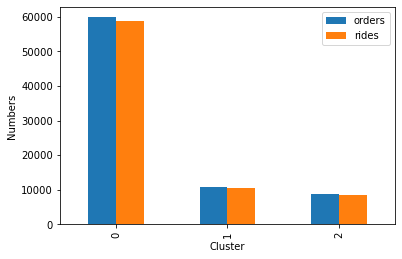

In [129]:
Order2Ride.iloc[:, 1:3].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Numbers')
plt.show()

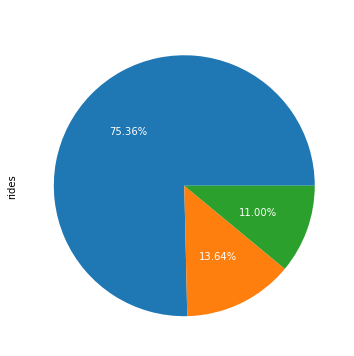

In [130]:
Order2Ride['rides'].plot(kind='pie', autopct = "%.2f%%", textprops={'color':"w"}, figsize=(6,6))
plt.title('Rides in clusters', color = 'w')
plt.show()

#### IQR по клиентскому чеку в разбивке по сегменту. 

In [131]:
df.head(2)

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude,monetary,frequency,recency,clusters,R_Quartile,F_Quartile,M_Quartile,RFMClass,hour,phase
73325,4139885053,2015-12-08 22:28:46,Эконом,2686729818,39262,1.86,57.584282,39.825794,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening
898708,3709831592,2015-12-19 22:42:40,Комфорт,2761390152,39262,2.79,57.584267,39.825745,57.584214,39.839829,54.655,25,0,0,1,1,2,112,22,Evening


In [132]:
cl_bill = data.groupby(['clusters'])['client_bill_usd'].mean()

In [133]:
from scipy.stats import iqr
iqr(cl_bill, axis = 0)

0.2497415946426269

#### IQR по клиентскому чеку в разбивке по городу.

In [134]:
city_bill = geo1.groupby(['city'])['client_bill_usd'].mean()

In [135]:
city_bill

city
Владимирская область    23.497106
Вологодская область      7.591019
Костромская область      8.072168
Ярославская область      4.295530
Name: client_bill_usd, dtype: float64

In [136]:
iqr(city_bill, axis = 0)

5.1612563806316984

#### средняяя длительность поездок по часам

In [137]:
orders.head()

,idhash_order,idhash_view,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status
0,3777115420,95199865,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP
1,2983673012,3853062057,2015-12-06 00:00:11,2015-12-06 00:00:12,NaT,NaT,NaT,2015-12-06 00:01:26,CC
2,2177076394,147233410,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP
3,1997846256,518227239,2015-12-06 00:00:32,2015-12-06 00:00:41,2015-12-06 00:04:04,2015-12-06 00:06:08,2015-12-06 00:17:11,NaT,CP
4,1893504594,3623774808,2015-12-06 00:01:07,2015-12-06 00:04:46,2015-12-06 00:11:35,2015-12-06 00:13:01,2015-12-06 00:29:43,NaT,CP


In [138]:
orders['r_hour'] = orders['order_dttm'].dt.hour
orders['r_minute'] = orders['order_dttm'].dt.minute
orders['r_second'] = orders['order_dttm'].dt.second

In [139]:
orders['time1'] = (3600*orders['r_hour'] + 60*orders['r_minute'] + orders['r_second'])/3600

In [140]:
orders = orders.drop(['r_hour','r_minute','r_second'],axis = 1).head(2) 

In [141]:
orders['r_hour'] = orders['finish_dttm'].dt.hour
orders['r_minute'] = orders['finish_dttm'].dt.minute
orders['r_second'] = orders['finish_dttm'].dt.second

In [142]:
orders['time2'] = (3600*orders['r_hour'] + 60*orders['r_minute'] + orders['r_second'])/3600

In [143]:
orders = orders.drop(['r_hour','r_minute','r_second'],axis = 1).head(2)

In [144]:
orders['duration'] = orders['time2'] - orders['time1']

In [145]:
orders['duration'].mean()

0.16583333333333333

## динамика ценообразования
(делим клиентский чек в рублях на длительность поездки в минутах и получаем стоимость за минуту и смотрим, как этот показатель меняется в течение суток и дней недели)

In [146]:
data.head(2)

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,...,monetary,frequency,recency,clusters,R_Quartile,F_Quartile,M_Quartile,RFMClass,hour,phase
0,3777115420,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP,992462937,2015-12-06 00:00:06,...,450.520,87,0,0,1,1,1,111,0,Night
2,2177076394,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP,1947282491,2015-12-06 00:00:25,...,335.105,104,0,0,1,1,1,111,0,Night


In [147]:
data['duration'] = orders['duration']*60

In [148]:
values = {'duration': data['duration'].mean()}
data = data.fillna(value=values)

In [149]:
data['dynamic'] = data['client_bill_usd'] / data['duration']

In [150]:
data['date'] = data['order_dttm'].dt.date

In [151]:
dyn = data.groupby(['date'])['dynamic'].mean()

In [152]:
dyn1 = data.groupby(['phase'])['dynamic'].mean()

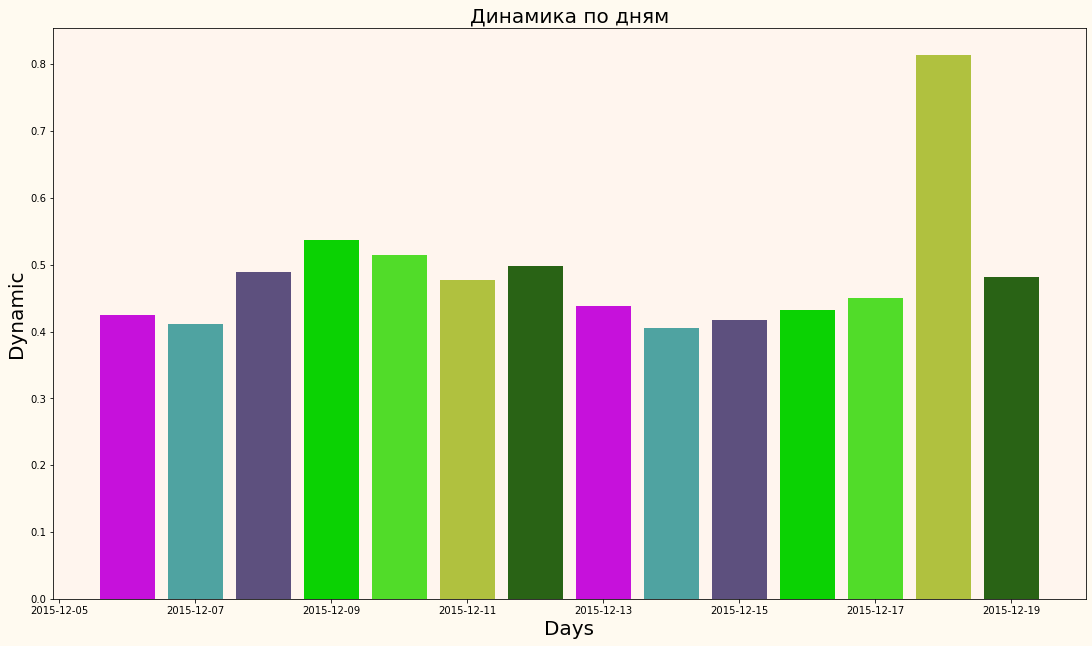

In [153]:
x = dyn.keys()
y1 = list(dyn)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

color_rectangle = np.random.rand(7, 3)    # RGB
ax.bar(x, y1, color = color_rectangle)

plt.title('Динамика по дням', fontsize=20)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Dynamic', fontsize=20)
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

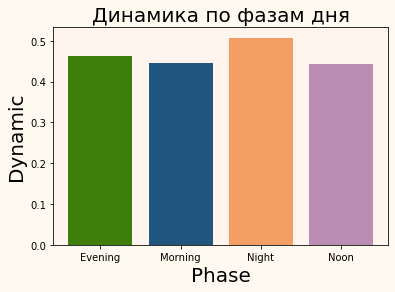

In [154]:
x = dyn1.keys()
y1 = list(dyn1)

fig, ax = plt.subplots()
#fig.set_size_inches(18.5, 10.5)

color_rectangle = np.random.rand(7, 3)    # RGB
ax.bar(x, y1, color = color_rectangle)

plt.title('Динамика по фазам дня', fontsize=20)
plt.xlabel('Phase', fontsize=20)
plt.ylabel('Dynamic', fontsize=20)
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

**Дополнительные задачи**
<br> 1) Визуализировать количество просмотров цены, заказов и поездок по гексагонам
<br> 2) Визуализировать View2Order по гексагонам 
<br> гексагоны должны быть раскрашлены в зависимости от значения показателя
<br> Можно использовать библиотку h3 или kepler.gl


In [155]:
geo1.head()

,cluster_label,city,idhash_client,idhash_view,view_dttm,tariff,idhash_order,client_bill_usd,latitude,longitude,del_latitude,del_longitude
0,0,Ярославская область,39262,156843244,2015-12-08 22:28:23,Эконом,0,1.86,57.584282,39.825794,57.584214,39.839829
0,0,Ярославская область,39262,4139885053,2015-12-08 22:28:46,Эконом,2686729818,1.86,57.584282,39.825794,57.584214,39.839829
0,0,Ярославская область,39262,2007943777,2015-12-08 22:28:51,Эконом,0,1.86,57.584282,39.825794,57.584214,39.839829
0,0,Ярославская область,39262,2066483825,2015-12-15 22:23:55,Эконом,0,1.46,57.584267,39.825745,57.584214,39.839829
0,0,Ярославская область,39262,1032456928,2015-12-15 22:31:55,Эконом,0,1.46,57.584267,39.825745,57.584214,39.839829


In [156]:
from keplergl import KeplerGl

In [ ]:
w1 = keplergl.KeplerGl(hight = 400, data={'data_1': df}, config = config)

In [164]:
map_1 = KeplerGl(height=400)
map_1.add_data(data=center_info, name='center')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [169]:
import json

In [170]:
geometryString = {
    'type': 'Polygon',
    'coordinates': [[[-74.158491,40.835947],[-74.148473,40.834522],[-74.142598,40.833128],[-74.151923,40.832074],[-74.158491,40.835947]]]
}

# create json string
json_str = json.dumps(geometryString)

# create data frame
df_with_geometry = pd.DataFrame({
    'id': [1],
    'geometry_string': [json_str]
})

# add to map
map_1.add_data(df_with_geometry, "df_with_geometry")